## Here are a few things I'd like to learn:
* Avalanching (slope failure)
* Vector-driven transport (eg., q = f(U,delz,c) where U=(u,v), delz = (dz/dx,dz/dy)
* Channel flow
* Boundaries - can vector be used to subdivide cells?
* What is the difference between a cell and a node?
* How to visualize vectors and gradients?

### See if the scarp model can have slope=limited transport

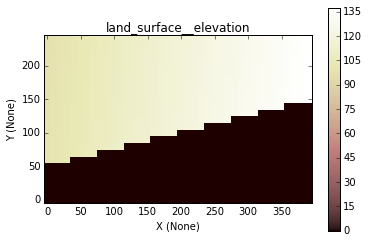

In [59]:
# sandwich wind model
import numpy as np
from landlab import RasterModelGrid, CLOSED_BOUNDARY

from landlab.components.diffusion.diffusion import LinearDiffuser
from landlab.plot.imshow import imshow_node_grid
from landlab.io.netcdf import *
from landlab.io import read_esri_ascii

from matplotlib import pyplot as plt
%matplotlib inline

mg = RasterModelGrid(25, 40, 10.0)
z = mg.add_zeros('node', 'land_surface__elevation')
fault_trace_y = 50.0 + 0.25*mg.node_x
upthrown_nodes = np.where(mg.node_y > fault_trace_y)
z[upthrown_nodes] += 100.0 + 0.1*mg.node_x[upthrown_nodes]-0.01*mg.node_y[upthrown_nodes]
imshow_node_grid(mg, 'land_surface__elevation')

mg.set_closed_boundaries_at_grid_edges(False, True, False, True)
core_nodes = mg.core_nodes

In [60]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2*mg.dx*mg.dx/D
print 'dt:',dt
g = mg.calculate_gradients_at_active_links(z)
np.max(g)
print 'Max slope: ',(180./np.pi)*np.arctan(np.max(g))

dt: 2000.0
Max slope:  85.8099922745


In [61]:
dtr = np.pi/180.
nts = 250
s = np.zeros(nts)
xok = np.logical_and(mg.node_x>=5,mg.node_x<=10)
yok = np.logical_and(mg.node_y>=5,mg.node_y<=10)
xyok = np.logical_and(xok,yok)
mg.status_at_node[xyok]= CLOSED_BOUNDARY

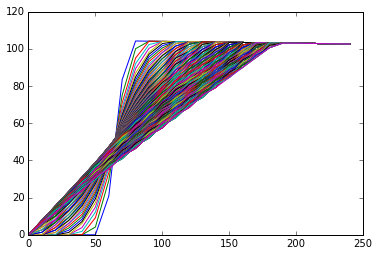

In [63]:
for i in range(nts):
    g = mg.calculate_gradients_at_active_links(z)
    qs = -D*g*(np.arctan(g)>(30.*dtr))
    s[i]=(180./np.pi)*np.arctan(np.mean(g))
    # print 'Max slope: ',s[i]
    dqsdx = mg.calculate_flux_divergence_at_nodes(qs)
    dzdt = -dqsdx
    z[core_nodes] += dzdt[core_nodes]*dt
    
    xsect = mg.node_vector_to_raster(z, flip_vertically=True)[:,5]
    ycoords = mg.node_vector_to_raster(mg.node_y, flip_vertically=True)[:,5]
    plt.plot(ycoords,xsect)

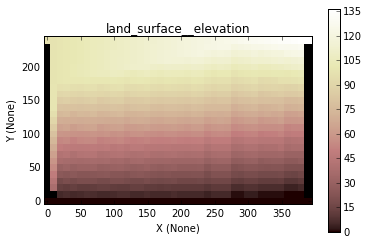

In [64]:
imshow_node_grid(mg, 'land_surface__elevation')